# Ch8 | SFT（Supervised Fine-Tuning）：让模型学会遵循指令

---

**目标：** 将基础模型转变为能够遵循指令的对话模型

**本 notebook 使用 中文 GPT-2 和 HuggingFace Transformers 演示真实的 SFT 训练。**

**设备建议：** GPU；CPU 仅建议阅读/演示。

---

## 内容

1. **SFT 原理**：从文本续写到对话
2. **ChatML 格式**：标准对话格式
3. **Loss Masking**：仅在 assistant 回复上计算损失
4. **真实训练**：对 中文 GPT-2 进行指令微调



## 预备知识

### 什么是 SFT？

**SFT（Supervised Fine-Tuning）** = 教模型“如何进行对话”

| | 基础模型 | 对话模型（SFT 后） |
|:---|:---|:---|
| 训练目标 | 预测下一个 token | 学习对话格式 |
| 输入 | 任意文本 | 结构化对话 |
| 输出 | 文本续写 | 有帮助的回复 |
| 使用场景 | 文本补全 | 聊天、问答、指令 |


## 环境准备


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Check available memory
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
Memory: 17.1 GB


In [2]:
# Install required packages if needed
try:
    from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
    from datasets import Dataset as HFDataset
    print("HuggingFace Transformers loaded successfully!")
except ImportError:
    print("Installing required packages...")
    !pip install transformers datasets accelerate -q
    from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
    from datasets import Dataset as HFDataset

# Try to import TRL for SFTTrainer (optional but recommended)
try:
    from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
    USE_TRL = True
    print("TRL library loaded - will use SFTTrainer")
except ImportError:
    USE_TRL = False
    print("TRL not available - will use standard Trainer")

HuggingFace Transformers loaded successfully!
TRL not available - will use standard Trainer


## Part 1：理解基础模型与对话模型


In [3]:
# Load GPT-2 Chinese (base model)
model_name = "uer/gpt2-chinese-cluecorpussmall"  # Chinese GPT-2 base

print(f"Loading {model_name}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
except Exception:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
base_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# GPT-2 doesn't have a pad token by default
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Model loaded: {sum(p.numel() for p in base_model.parameters()):,} parameters")


Loading uer/gpt2-chinese-cluecorpussmall...
Model loaded: 102,068,736 parameters


In [4]:
def generate_text(model, tokenizer, prompt, max_new_tokens=50, temperature=0.7, do_sample=True, top_p=0.9):
    """
    Generate text from a prompt.
    """
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id
    if model.generation_config.pad_token_id is None:
        model.generation_config.pad_token_id = tokenizer.pad_token_id

    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.pad_token_id,
        "repetition_penalty": 1.1,
        "no_repeat_ngram_size": 3,
    }
    if do_sample:
        gen_kwargs["temperature"] = temperature
        gen_kwargs["top_p"] = top_p

    input_len = inputs['input_ids'].shape[-1]
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **gen_kwargs,
        )

    gen_ids = outputs[0][input_len:]
    return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

# Test base model behavior
print("=" * 60)
print("BASE MODEL BEHAVIOR (before SFT)")
print("=" * 60)

test_prompts = [
    "What is machine learning?",
    "Question: What is 2+2?\nAnswer:",
    "User: Hello!\nAssistant:",
]

for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    print(f"Output: {generate_text(base_model, tokenizer, prompt, max_new_tokens=30)}")
    print("-" * 40)


BASE MODEL BEHAVIOR (before SFT)

Prompt: What is machine learning?
Output: ???? -?.??? ( 2014 年 )? ( 2013 年 )?? 2.
----------------------------------------

Prompt: Question: What is 2+2?
Answer:
Output: ? in order ， and order. [ photo ] : indeal and communication ; indicated.
----------------------------------------

Prompt: User: Hello!
Assistant:
Output: !!!! |!!!? | | |?! | | |!
----------------------------------------


如你所见，基础模型并不理解指令格式——它只会沿着输入的风格继续生成文本。

## Part 2：ChatML 格式

ChatML 是一种用于表示对话的标准格式：


In [5]:
# Define special tokens for chat format
SPECIAL_TOKENS = {
    "bos_token": "<|startoftext|>",
    "eos_token": "<|endoftext|>",
    "pad_token": "<|pad|>",
    "additional_special_tokens": [
        "<|im_start|>",
        "<|im_end|>",
        "<|user|>",
        "<|assistant|>",
        "<|system|>",
    ]
}

def format_conversation(messages: List[Dict[str, str]], tokenizer=None) -> str:
    """
    Convert a conversation to ChatML format.
    
    Args:
        messages: List of {"role": str, "content": str} dicts
        tokenizer: Optional tokenizer for encoding
    
    Returns:
        Formatted conversation string
    """
    formatted = ""
    for msg in messages:
        role = msg["role"]
        content = msg["content"]
        formatted += f"<|im_start|>{role}\n{content}<|im_end|>\n"
    return formatted

# Example conversation
example_conv = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "What is Python?"},
    {"role": "assistant", "content": "Python is a high-level programming language known for its simplicity and readability."},
]

print("ChatML Format Example:")
print("=" * 60)
print(format_conversation(example_conv))

ChatML Format Example:
<|im_start|>system
You are a helpful AI assistant.<|im_end|>
<|im_start|>user
What is Python?<|im_end|>
<|im_start|>assistant
Python is a high-level programming language known for its simplicity and readability.<|im_end|>



## Part 3：SFT 训练数据

默认使用“诉求分类”数据集（gpt2_sft_*.jsonl），也可以切换到 JSON 抽取任务（custom_sft_*.jsonl）。
JSON 抽取时字段：name / email / order_id（只输出 JSON）。


In [6]:
# Structured SFT training data from data/ (train/val/test splits)
import json
from pathlib import Path
import os

def resolve_data_dir():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        data_dir = base / "data"
        if data_dir.exists():
            return str(data_dir)
    return os.path.join(os.getcwd(), "data")

DATA_DIR = resolve_data_dir()


def load_jsonl(path):
    with open(path, "r", encoding="utf-8-sig") as f:
        return [json.loads(line) for line in f if line.strip()]

# Task selection: classification or JSON extraction
SFT_TASK = "classification"  # "classification" or "json_extraction"
USE_PLAIN_EXTRACT = False  # Only for json_extraction

if SFT_TASK == "classification":
    # Optional: regenerate a simpler, Chinese-only classification dataset
    REGEN_SFT_DATA = True
    ISSUE_LABELS = ["延迟发货", "退款申请", "地址修改", "物流异常", "售后咨询", "发票问题"]
    TASK_LABELS = ISSUE_LABELS
    TRAIN_FILE = "gpt2_sft_train.jsonl"
    VAL_FILE = "gpt2_sft_val.jsonl"
    TEST_FILE = "gpt2_sft_test.jsonl"
else:
    REGEN_SFT_DATA = False
    ISSUE_LABELS = []
    TASK_LABELS = None
    TRAIN_FILE = "custom_sft_train.jsonl"
    VAL_FILE = "custom_sft_val.jsonl"
    TEST_FILE = "custom_sft_test.jsonl"

if SFT_TASK != "json_extraction":
    USE_PLAIN_EXTRACT = False


def _rand_order_id(rng):
    year = rng.choice([2024, 2025])
    month = rng.randint(1, 12)
    day = rng.randint(1, 28)
    return f"OD{year:04d}{month:02d}{day:02d}-{rng.randint(1000, 9999)}"


def _generate_records(count, seed):
    import random
    rng = random.Random(seed)
    names = [
        ("陈洁", "chen.jie"), ("孙悦", "sun.yue"), ("张强", "zhang.qiang"), ("周凯", "zhou.kai"),
        ("刘洋", "liu.yang"), ("王伟", "wang.wei"), ("吴磊", "wu.lei"), ("李娜", "li.na"),
        ("赵敏", "zhao.min"), ("黄涛", "huang.tao"), ("郭婷", "guo.ting"), ("马超", "ma.chao"),
    ]
    templates = [
        "客户{name}（{email}）反馈订单{order_id}{issue}。",
        "订单{order_id}相关用户{name}邮箱{email}，问题：{issue}。",
        "请处理：姓名{name}，邮箱{email}，订单号{order_id}，原因：{issue}。",
        "用户{name}邮箱{email}，订单{order_id}需要处理：{issue}。",
        "{name}反馈订单{order_id}{issue}，联系邮箱{email}。",
    ]

    records = []
    for _ in range(count):
        name, email_user = rng.choice(names)
        email = f"{email_user}@example.com"
        order_id = _rand_order_id(rng)
        issue = rng.choice(ISSUE_LABELS)
        text = rng.choice(templates).format(
            name=name,
            email=email,
            order_id=order_id,
            issue=issue,
        )
        instruction = (
            "请判断用户诉求类别，只输出类别（" + "/".join(ISSUE_LABELS) + "）。"
            f"文本：{text}"
        )
        response = issue
        records.append({
            "instruction": instruction,
            "response": response,
            "category": "诉求分类",
            "metric": "text",
            "expected": response,
        })
    return records


def _write_jsonl(path, records):
    with open(path, "w", encoding="utf-8") as f:
        for record in records:
            f.write(json.dumps(record, ensure_ascii=False) + "\n")


if REGEN_SFT_DATA and SFT_TASK == "classification":
    train_records = _generate_records(8000, seed=42)
    val_records = _generate_records(1000, seed=43)
    test_records = _generate_records(1000, seed=44)
    _write_jsonl(os.path.join(DATA_DIR, "gpt2_sft_train.jsonl"), train_records)
    _write_jsonl(os.path.join(DATA_DIR, "gpt2_sft_val.jsonl"), val_records)
    _write_jsonl(os.path.join(DATA_DIR, "gpt2_sft_test.jsonl"), test_records)
    print("Regenerated gpt2_sft_*.jsonl with classification labels")

TRAIN_RECORDS = load_jsonl(os.path.join(DATA_DIR, TRAIN_FILE))
VAL_RECORDS = load_jsonl(os.path.join(DATA_DIR, VAL_FILE))
TEST_RECORDS = load_jsonl(os.path.join(DATA_DIR, TEST_FILE))


def build_plain_instruction(record):
    instruction = record["instruction"]
    text = instruction
    if "文本：" in instruction:
        text = instruction.split("文本：", 1)[-1]
    return (
        "从文本中抽取姓名、邮箱、订单号，按“姓名：…；邮箱：…；订单号：…”格式回答。"
        f"文本：{text}"
    )


def build_plain_response(record):
    try:
        obj = json.loads(record["response"])
    except Exception:
        return record["response"]
    return f"姓名：{obj.get('name','')}；邮箱：{obj.get('email','')}；订单号：{obj.get('order_id','')}"


def to_messages(record):
    if USE_PLAIN_EXTRACT:
        user_text = build_plain_instruction(record)
        assistant_text = build_plain_response(record)
    else:
        user_text = record["instruction"]
        assistant_text = record["response"]
    return {
        "messages": [
            {"role": "user", "content": user_text},
            {"role": "assistant", "content": assistant_text},
        ]
    }


TRAIN_DATA = [to_messages(r) for r in TRAIN_RECORDS]
VAL_DATA = [to_messages(r) for r in VAL_RECORDS]
TEST_DATA = [to_messages(r) for r in TEST_RECORDS]

print(f"SFT task: {SFT_TASK}")
print(f"Train: {len(TRAIN_DATA)} | Val: {len(VAL_DATA)} | Test: {len(TEST_DATA)}")
print(f"Categories: {sorted(set(r['category'] for r in TRAIN_RECORDS))}")
print(f"Example: {TRAIN_DATA[0]['messages']}")


Regenerated gpt2_sft_*.jsonl with classification labels
SFT task: classification
Train: 8000 | Val: 1000 | Test: 1000
Categories: ['诉求分类']
Example: [{'role': 'user', 'content': '请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：订单OD20240124-5506相关用户郭婷邮箱guo.ting@example.com，问题：退款申请。'}, {'role': 'assistant', 'content': '退款申请'}]


## Part 4：Loss Masking

SFT 的关键点：**只在 assistant 回复上计算 loss**，而不是在 user 输入上计算。


In [7]:
class SFTDataset(torch.utils.data.Dataset):
    """
    Dataset for Supervised Fine-Tuning with proper loss masking.
    
    Key features:
    - Formats conversations in ChatML style
    - Creates labels with -100 for non-assistant tokens (loss masking)
    - Handles variable length sequences
    """
    
    def __init__(
        self,
        data: List[Dict],
        tokenizer,
        max_length: int = 512,
        mask_prompt: bool = True
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_prompt = mask_prompt
        
        # Pre-process all examples
        self.processed = []
        for item in data:
            processed = self._process_example(item)
            if processed is not None:
                self.processed.append(processed)
        
        print(f"Processed {len(self.processed)}/{len(data)} examples")
    
    def _process_example(self, item: Dict) -> Optional[Dict]:
        """
        Process a single conversation example.
        
        Returns:
            Dict with input_ids, attention_mask, and labels
        """
        messages = item['messages']
        
        # Build the full conversation text and track assistant positions
        full_text = ""
        assistant_ranges = []  # List of (start, end) character positions for assistant responses
        
        for msg in messages:
            role = msg['role']
            content = msg['content']
            
            msg_text = f"<|im_start|>{role}\n{content}<|im_end|>\n"
            
            if role == 'assistant':
                # Track where assistant content starts and ends
                content_start = len(full_text) + len(f"<|im_start|>{role}\n")
                content_end = content_start + len(content)
                assistant_ranges.append((content_start, content_end))
            
            full_text += msg_text
        
        # Tokenize
        encoding = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
            return_offsets_mapping=getattr(self.tokenizer, "is_fast", False)
        )
        
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Create labels: -100 for tokens we don't want to compute loss on
        if self.mask_prompt:
            labels = torch.full_like(input_ids, -100)
            offsets = encoding.get('offset_mapping')
            if offsets is not None:
                offsets = offsets.squeeze(0).tolist()
                for i, (start_char, end_char) in enumerate(offsets):
                    if start_char == 0 and end_char == 0:
                        continue
                    for a_start, a_end in assistant_ranges:
                        if start_char < a_end and end_char > a_start:
                            labels[i] = input_ids[i]
                            break
            else:
                # Fallback approximate mapping for non-fast tokenizers
                for start_char, end_char in assistant_ranges:
                    prefix = full_text[:start_char]
                    prefix_tokens = self.tokenizer(prefix, add_special_tokens=False)['input_ids']
                    start_token = len(prefix_tokens)

                    content_text = full_text[:end_char]
                    content_tokens = self.tokenizer(content_text, add_special_tokens=False)['input_ids']
                    end_token = len(content_tokens)

                    if start_token < self.max_length and end_token <= self.max_length:
                        labels[start_token:end_token] = input_ids[start_token:end_token]
        else:
            labels = input_ids.clone()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }
    
    def __len__(self):
        return len(self.processed)
    
    def __getitem__(self, idx):
        return self.processed[idx]

In [8]:
# Visualize loss masking
def visualize_loss_masking(example: Dict, tokenizer):
    """
    Visualize which tokens have loss computed vs masked.
    """
    input_ids = example['input_ids']
    labels = example['labels']
    
    # Only show non-padding tokens
    valid_len = (input_ids != tokenizer.pad_token_id).sum().item()
    input_ids = input_ids[:valid_len]
    labels = labels[:valid_len]
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    print("Loss Masking Visualization:")
    print("=" * 60)
    print("Green = Loss computed (assistant)")
    print("Red = Loss masked (user/system)")
    print("=" * 60)
    
    # Print tokens with colors
    for i, (token, label) in enumerate(zip(tokens[:50], labels[:50])):  # First 50 tokens
        if label == -100:
            print(f"\033[91m{token}\033[0m", end=" ")  # Red
        else:
            print(f"\033[92m{token}\033[0m", end=" ")  # Green
    print("\n")
    
    # Statistics
    masked = (labels == -100).sum().item()
    total = len(labels)
    print(f"\nMasked tokens: {masked}/{total} ({100*masked/total:.1f}%)")
    print(f"Loss computed on: {total-masked}/{total} ({100*(total-masked)/total:.1f}%)")

## Part 5：使用 GPT-2 进行真实 SFT 训练

现在开始实际对 GPT-2 做微调！


In [9]:
# Add special tokens to tokenizer
print("Adding special tokens...")

from pathlib import Path

if "DATA_DIR" in globals():
    base_dir = Path(DATA_DIR).parent
else:
    base_dir = Path.cwd()
    if not (base_dir / "models").exists() and (base_dir.parent / "models").exists():
        base_dir = base_dir.parent

SFT_SAVE_DIR = base_dir / "models" / "ch8_sft_gpt2"
LOAD_SFT_MODEL = False  # Set True to load a saved SFT model

if LOAD_SFT_MODEL and SFT_SAVE_DIR.exists():
    sft_tokenizer = AutoTokenizer.from_pretrained(SFT_SAVE_DIR)
    sft_model = AutoModelForCausalLM.from_pretrained(SFT_SAVE_DIR).to(device)
    print(f"Loaded SFT model from {SFT_SAVE_DIR}")
else:
    # Create a fresh tokenizer and model for SFT
    try:
        sft_tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    except Exception:
        sft_tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

    # Add special tokens
    special_tokens = {
        'pad_token': '<|pad|>',
        'additional_special_tokens': ['<|im_start|>', '<|im_end|>']
    }
    num_added = sft_tokenizer.add_special_tokens(special_tokens)

    # Add ASCII tokens to avoid [UNK] for IDs/emails (WordPiece uses ## for subwords)
    import string
    ascii_chars = list(string.ascii_lowercase + string.ascii_uppercase + string.digits + "@._-")
    json_tokens = ["{", "}", "\"", ":", ","]
    key_tokens = ["name", "email", "order_id", "OD", "od"]
    extra_tokens = ascii_chars + [f"##{ch}" for ch in ascii_chars] + json_tokens + key_tokens
    num_added += sft_tokenizer.add_tokens(extra_tokens)
    print(f"Added {num_added} total tokens (special + ASCII)")

    # Create model and resize embeddings
    sft_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    sft_model.resize_token_embeddings(len(sft_tokenizer))

if sft_tokenizer.pad_token_id is None:
    sft_tokenizer.pad_token = sft_tokenizer.eos_token
sft_model.config.pad_token_id = sft_tokenizer.pad_token_id
sft_model.generation_config.pad_token_id = sft_tokenizer.pad_token_id

# Sanity check: ensure key patterns have no [UNK]
sample_texts = [
    '{"name":"张强","email":"zhang.qiang@example.com","order_id":"OD20250425-2019"}',
    '{"name":"孙悦","email":"sun.yue@example.com","order_id":"OD20250424-1269"}'
]
has_unk = False
for text in sample_texts:
    tokens = sft_tokenizer.tokenize(text)
    if "[UNK]" in tokens:
        has_unk = True
        print("Tokenizer UNK in sample:", text)
        print(tokens)
if not has_unk:
    print("Tokenizer OK: no [UNK] in JSON/email/order_id samples")

print(f"Vocabulary size: {len(sft_tokenizer)}")
print(f"Model parameters: {sum(p.numel() for p in sft_model.parameters()):,}")

Adding special tokens...
Added 145 total tokens (special + ASCII)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer OK: no [UNK] in JSON/email/order_id samples
Vocabulary size: 21186
Model parameters: 102,113,280


In [10]:
# Create SFT dataset
print("Creating SFT dataset...")
MASK_PROMPT = True  # Only compute loss on assistant responses
if not MASK_PROMPT:
    print("Warning: mask_prompt=False will train on user tokens; outputs may echo prompts and evaluation will be noisy.")

train_dataset = SFTDataset(
    data=TRAIN_DATA,
    tokenizer=sft_tokenizer,
    max_length=256,
    mask_prompt=MASK_PROMPT
)

val_dataset = SFTDataset(
    data=VAL_DATA,
    tokenizer=sft_tokenizer,
    max_length=256,
    mask_prompt=MASK_PROMPT
)

print(f"Train dataset: {len(train_dataset)}")
print(f"Val dataset: {len(val_dataset)}")

# Visualize an example
visualize_loss_masking(train_dataset[0], sft_tokenizer)


Creating SFT dataset...
Processed 8000/8000 examples
Processed 1000/1000 examples
Train dataset: 8000
Val dataset: 1000
Loss Masking Visualization:
Green = Loss computed (assistant)
Red = Loss masked (user/system)
[CLS] <|im_start|> u s e r 请 判 断 用 户 诉 求 类 别 ， 只 输 出 类 别 （ 延 迟 发 货 / 退 款 申 请 / 地 址 修 改 / 物 流 异 常 / 售 后 咨 询 / 发 票 问 


Masked tokens: 122/126 (96.8%)
Loss computed on: 4/126 (3.2%)


In [11]:
# Training configuration
BATCH_SIZE = 4
NUM_EPOCHS = 3
MAX_STEPS = 1000  # Set to None to disable early stop
LEARNING_RATE = 5e-5
WARMUP_STEPS = 50

# Create data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(sft_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

estimated_steps = len(train_dataloader) * NUM_EPOCHS
if MAX_STEPS is None:
    total_steps = estimated_steps
else:
    total_steps = min(estimated_steps, MAX_STEPS)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=WARMUP_STEPS
)

print(f"Training configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Total steps: {total_steps}")
print(f"  Max steps: {MAX_STEPS}")


Training configuration:
  Batch size: 4
  Epochs: 3
  Learning rate: 5e-05
  Total steps: 1000
  Max steps: 1000


In [12]:
# SFT Training Loop
print("\n" + "="*60)
print("Starting SFT Training")
print("="*60)

SAVE_SFT_MODEL = True  # Set False to skip saving

def evaluate_loss(dataloader):
    sft_model.eval()
    total_loss = 0
    total_batches = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = sft_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            total_loss += outputs.loss.item()
            total_batches += 1

    return total_loss / max(total_batches, 1)

sft_model.train()
training_losses = []
step = 0
stop_training = False

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    num_batches = 0

    sft_model.train()
    for batch in train_dataloader:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = sft_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sft_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        num_batches += 1
        step += 1

        if step % 20 == 0:
            training_losses.append(loss.item())
            print(f"Step {step:4d} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

        if MAX_STEPS is not None and step >= MAX_STEPS:
            stop_training = True
            break

    avg_epoch_loss = epoch_loss / max(num_batches, 1)
    val_loss = evaluate_loss(val_dataloader)
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} completed")
    print(f"  Train loss: {avg_epoch_loss:.4f}")
    print(f"  Val loss:   {val_loss:.4f}")

    if stop_training:
        print(f"Reached MAX_STEPS={MAX_STEPS}, stopping early.")
        break

if SAVE_SFT_MODEL:
    SFT_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    sft_model.save_pretrained(SFT_SAVE_DIR)
    sft_tokenizer.save_pretrained(SFT_SAVE_DIR)

    meta = {
        "task": SFT_TASK,
        "use_plain_extract": USE_PLAIN_EXTRACT,
        "labels": TASK_LABELS,
        "model_name": model_name,
    }
    with open(SFT_SAVE_DIR / "sft_task.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print(f"Saved SFT model to {SFT_SAVE_DIR}")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



Starting SFT Training
Step   20 | Loss: 0.0055 | LR: 2.30e-05
Step   40 | Loss: 0.0001 | LR: 4.10e-05
Step   60 | Loss: 0.0000 | LR: 5.00e-05
Step   80 | Loss: 0.0000 | LR: 5.00e-05
Step  100 | Loss: 0.0001 | LR: 5.00e-05
Step  120 | Loss: 0.0000 | LR: 5.00e-05
Step  140 | Loss: 0.0000 | LR: 5.00e-05
Step  160 | Loss: 0.0000 | LR: 5.00e-05
Step  180 | Loss: 0.0000 | LR: 5.00e-05
Step  200 | Loss: 0.0000 | LR: 5.00e-05
Step  220 | Loss: 0.0000 | LR: 5.00e-05
Step  240 | Loss: 0.0000 | LR: 5.00e-05
Step  260 | Loss: 0.0000 | LR: 5.00e-05
Step  280 | Loss: 0.0000 | LR: 5.00e-05
Step  300 | Loss: 0.0000 | LR: 5.00e-05
Step  320 | Loss: 0.0000 | LR: 5.00e-05
Step  340 | Loss: 0.0000 | LR: 5.00e-05
Step  360 | Loss: 0.0000 | LR: 5.00e-05
Step  380 | Loss: 0.0000 | LR: 5.00e-05
Step  400 | Loss: 0.0000 | LR: 5.00e-05
Step  420 | Loss: 0.0000 | LR: 5.00e-05
Step  440 | Loss: 0.0000 | LR: 5.00e-05
Step  460 | Loss: 0.0000 | LR: 5.00e-05
Step  480 | Loss: 0.0000 | LR: 5.00e-05
Step  500 | Loss:

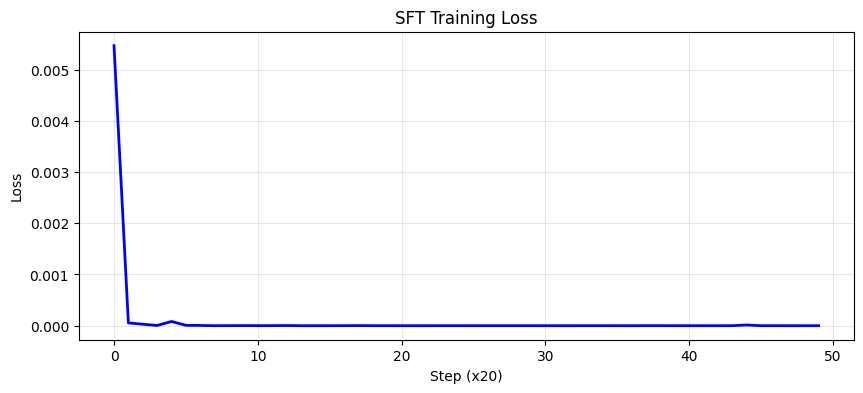

In [13]:
# Visualize training progress
plt.figure(figsize=(10, 4))
plt.plot(training_losses, 'b-', linewidth=2)
plt.xlabel('Step (x20)')
plt.ylabel('Loss')
plt.title('SFT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## Part 6：评估微调后的模型


In [14]:
import re

def generate_response(model, tokenizer, user_message: str, max_new_tokens: int = 100, temperature: float = 0.7, do_sample: bool = True, top_p: float = 0.9) -> str:
    """
    Generate a response using the fine-tuned model.
    """
    model.eval()

    # Format as conversation
    prompt = f"<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant\n"

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id
    if model.generation_config.pad_token_id is None:
        model.generation_config.pad_token_id = tokenizer.pad_token_id

    eos_id = tokenizer.convert_tokens_to_ids('<|im_end|>')
    if eos_id is None or eos_id == tokenizer.unk_token_id:
        eos_id = tokenizer.eos_token_id

    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": eos_id,
        "repetition_penalty": 1.1,
        "no_repeat_ngram_size": 3,
    }
    if do_sample:
        gen_kwargs["temperature"] = temperature
        gen_kwargs["top_p"] = top_p

    input_len = inputs['input_ids'].shape[-1]
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **gen_kwargs,
        )

    gen_ids = outputs[0][input_len:]
    gen_text = tokenizer.decode(gen_ids, skip_special_tokens=False)
    gen_text = gen_text.replace("[CLS]", "").replace("[SEP]", "").strip()
    if "<|im_end|>" in gen_text:
        gen_text = gen_text.split("<|im_end|>")[0]
    return gen_text.strip()


In [15]:
# Quantitative evaluation on held-out test set
import re
import json

def clean_generated(text):
    if text is None:
        return ""
    cleaned = text.replace("[CLS]", "").replace("[SEP]", "")
    for token in ["<|im_start|>", "<|im_end|>", "<|assistant|>", "<|user|>", "<|system|>"]:
        cleaned = cleaned.replace(token, "")
    return cleaned.strip()

def normalize_text(text):
    text = clean_generated(text)
    return " ".join(text.strip().lower().split())

def extract_number(text):
    match = re.search(r"-?\d+", text)
    return match.group(0) if match else None

def extract_json(text):
    text = clean_generated(text)
    matches = re.findall(r"\{.*?\}", text, flags=re.DOTALL)
    if not matches:
        return None
    for candidate in reversed(matches):
        try:
            return json.loads(candidate)
        except Exception:
            continue
    return None

def _to_ascii_digits(text: str) -> str:
    return text.translate(str.maketrans("０１２３４５６７８９", "0123456789"))

def _normalize_json_key(key: str) -> str:
    key = key.replace("##", "")
    key = re.sub(r"\s+", "", key)
    key = re.sub(r"_+", "_", key)
    if key == "orderid":
        key = "order_id"
    return _to_ascii_digits(key)

def _normalize_json_value(val):
    if isinstance(val, str):
        val = val.replace("##", "")
        val = re.sub(r"\s+", "", val)
        return _to_ascii_digits(val)
    return val

def normalize_json_obj(obj):
    if not isinstance(obj, dict):
        return obj
    normalized = {}
    for k, v in obj.items():
        nk = _normalize_json_key(k)
        nv = _normalize_json_value(v)
        normalized[nk] = nv
    return normalized

USE_PLAIN_EVAL = USE_PLAIN_EXTRACT

def _normalize_text_for_eval(text: str) -> str:
    text = clean_generated(text)
    text = text.replace("##", "")
    text = _to_ascii_digits(text)
    return re.sub(r"\s+", "", text)

def parse_plain_fields(text: str):
    text = _normalize_text_for_eval(text)
    name = None
    email = None
    order_id = None

    m = re.search(r"姓名[:：]?([^；;，,。\n]+)", text)
    if m:
        name = m.group(1)

    m = re.search(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", text)
    if m:
        email = m.group(0)

    m = re.search(r"OD\d{8}-\d{4}", text)
    if m:
        order_id = m.group(0)

    if not (name and email and order_id):
        return None
    return {"name": name, "email": email, "order_id": order_id}

def score_prediction(pred, record):
    pred = clean_generated(pred)
    pred_norm = normalize_text(pred)
    expected = record["expected"]
    expected_norm = normalize_text(expected)
    metric = record["metric"]

    if metric == "numeric":
        return extract_number(pred_norm) == expected

    if metric == "json":
        if USE_PLAIN_EVAL:
            pred_obj = parse_plain_fields(pred)
            try:
                expected_obj = json.loads(expected)
            except Exception:
                expected_obj = None
            if pred_obj is None or expected_obj is None:
                return False
            return normalize_json_obj(pred_obj) == normalize_json_obj(expected_obj)

        pred_obj = extract_json(pred)
        try:
            expected_obj = json.loads(expected)
        except Exception:
            expected_obj = None
        if pred_obj is None or expected_obj is None:
            return False
        return normalize_json_obj(pred_obj) == normalize_json_obj(expected_obj)

    return expected_norm in pred_norm

EVAL_MAX_SAMPLES = 200  # Set None for full test set
EVAL_PROGRESS_EVERY = 50
EVAL_MAX_NEW_TOKENS = 120
EVAL_DO_SAMPLE = False
EVAL_TEMPERATURE = 0.0
EVAL_TOP_P = 1.0
EVAL_RUN_BASE = True
USE_LM_CLASSIFIER = TASK_LABELS is not None

def _build_prompt(instruction, use_chatml):
    if use_chatml:
        return f"<|im_start|>user\n{instruction}<|im_end|>\n<|im_start|>assistant\n"
    return instruction

def _lm_classify(model, tok, prompt, labels):
    prompt_ids = tok(prompt, add_special_tokens=False)["input_ids"]
    if not prompt_ids:
        return labels[0]
    best_label = labels[0]
    best_score = float("-inf")
    for label in labels:
        label_ids = tok(label, add_special_tokens=False)["input_ids"]
        input_ids = torch.tensor([prompt_ids + label_ids]).to(device)
        with torch.no_grad():
            logits = model(input_ids).logits
        start = len(prompt_ids)
        if start == 0 or len(label_ids) == 0:
            continue
        log_probs = torch.log_softmax(logits[0, start - 1:start - 1 + len(label_ids)], dim=-1)
        target = input_ids[0, start:start + len(label_ids)]
        token_logprobs = log_probs.gather(1, target.unsqueeze(1)).squeeze(1)
        score = token_logprobs.mean().item()
        if score > best_score:
            best_score = score
            best_label = label
    return best_label

def run_model(model, instruction, use_chatml):
    if USE_LM_CLASSIFIER and TASK_LABELS:
        prompt = _build_prompt(instruction, use_chatml)
        tok = sft_tokenizer if use_chatml else tokenizer
        return _lm_classify(model, tok, prompt, TASK_LABELS)
    if use_chatml:
        return generate_response(
            model,
            sft_tokenizer,
            instruction,
            max_new_tokens=EVAL_MAX_NEW_TOKENS,
            temperature=EVAL_TEMPERATURE,
            do_sample=EVAL_DO_SAMPLE,
            top_p=EVAL_TOP_P
        )
    return generate_text(
        model,
        tokenizer,
        instruction,
        max_new_tokens=EVAL_MAX_NEW_TOKENS,
        temperature=EVAL_TEMPERATURE,
        do_sample=EVAL_DO_SAMPLE,
        top_p=EVAL_TOP_P
    )

def evaluate_model(model, use_chatml):
    results = {}
    samples = []
    records = TEST_RECORDS if EVAL_MAX_SAMPLES is None else TEST_RECORDS[:EVAL_MAX_SAMPLES]
    total = len(records)
    for idx, record in enumerate(records, 1):
        pred = run_model(model, record["instruction"], use_chatml)
        correct = score_prediction(pred, record)
        results.setdefault(record["category"], []).append(correct)
        if len(samples) < 3:
            samples.append((record["instruction"], record["expected"], pred))
        if EVAL_PROGRESS_EVERY and (idx % EVAL_PROGRESS_EVERY == 0 or idx == total):
            print(f"  evaluated {idx}/{total}")

    summary = {cat: sum(vals) / len(vals) for cat, vals in results.items()}
    summary["overall"] = sum(sum(v) for v in results.values()) / sum(len(v) for v in results.values())
    return summary, samples

print("Evaluation on held-out test set")
print("=" * 60)

base_summary = {}
base_samples = []
if EVAL_RUN_BASE:
    base_summary, base_samples = evaluate_model(base_model, use_chatml=False)
sft_summary, sft_samples = evaluate_model(sft_model, use_chatml=True)

if EVAL_RUN_BASE:
    print("\nBase model:")
    for cat, acc in base_summary.items():
        print(f"  {cat}: {acc*100:.1f}%" if cat != "overall" else f"  overall: {acc*100:.1f}%")

print("\nSFT model:")
for cat, acc in sft_summary.items():
    print(f"  {cat}: {acc*100:.1f}%" if cat != "overall" else f"  overall: {acc*100:.1f}%")

print("\nSamples (SFT):")
for ins, exp, pred in sft_samples:
    print(f"  Q: {ins}")
    print(f"  Expected: {exp}")
    print(f"  Pred: {pred[:80]}")
    print("  ---")


Evaluation on held-out test set
  evaluated 50/200
  evaluated 100/200
  evaluated 150/200
  evaluated 200/200
  evaluated 50/200
  evaluated 100/200
  evaluated 150/200
  evaluated 200/200

Base model:
  诉求分类: 91.5%
  overall: 91.5%

SFT model:
  诉求分类: 100.0%
  overall: 100.0%

Samples (SFT):
  Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：客户吴磊（wu.lei@example.com）反馈订单OD20240313-4689地址修改。
  Expected: 地址修改
  Pred: 地址修改
  ---
  Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：周凯反馈订单OD20241001-2641退款申请，联系邮箱zhou.kai@example.com。
  Expected: 退款申请
  Pred: 退款申请
  ---
  Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：用户马超邮箱ma.chao@example.com，订单OD20251221-7200需要处理：售后咨询。
  Expected: 售后咨询
  Pred: 售后咨询
  ---


In [16]:
# Side-by-side comparison on a few test items
print("\nComparison: Base vs SFT")
print("=" * 60)

for record in TEST_RECORDS[:5]:
    instruction = record["instruction"]
    expected = record["expected"]
    base_pred = run_model(base_model, instruction, use_chatml=False)
    sft_pred = run_model(sft_model, instruction, use_chatml=True)

    print(f"\nQ: {instruction}")
    print(f"Expected: {expected}")
    print(f"Base: {base_pred[:80]}")
    print(f"SFT:  {sft_pred[:80]}")
    print("-" * 40)



Comparison: Base vs SFT

Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：客户吴磊（wu.lei@example.com）反馈订单OD20240313-4689地址修改。
Expected: 地址修改
Base: 地址修改
SFT:  地址修改
----------------------------------------

Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：周凯反馈订单OD20241001-2641退款申请，联系邮箱zhou.kai@example.com。
Expected: 退款申请
Base: 退款申请
SFT:  退款申请
----------------------------------------

Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：用户马超邮箱ma.chao@example.com，订单OD20251221-7200需要处理：售后咨询。
Expected: 售后咨询
Base: 售后咨询
SFT:  售后咨询
----------------------------------------

Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：马超反馈订单OD20250603-6551地址修改，联系邮箱ma.chao@example.com。
Expected: 地址修改
Base: 延迟发货
SFT:  地址修改
----------------------------------------

Q: 请判断用户诉求类别，只输出类别（延迟发货/退款申请/地址修改/物流异常/售后咨询/发票问题）。文本：请处理：姓名张强，邮箱zhang.qiang@example.com，订单号OD20240903-2550，原因：地址修改。
Expected: 地址修改
Base: 延迟发货
SFT:  地址修改
----------------------------------------


## 总结

1. **SFT 的作用**：将只会文本续写的基础模型训练为能遵循指令、进行对话的模型

2. **ChatML 格式**：用角色标记（`<|im_start|>`, `<|im_end|>`）表示对话的标准方式

3. **Loss Masking**：关键技术——只在 assistant 回复上计算 loss（在 labels 中用 -100 屏蔽）

4. **真实训练**：我们实际微调了 GPT-2，并看到它学会以对话形式回答问题

### 关键要点

| 维度 | 说明 |
|--------|--------|
| **数据** | 高质量的（instruction, response）样本对 |
| **格式** | ChatML 或类似的结构化格式 |
| **Loss** | 仅对 assistant tokens 计算（-100 mask） |
| **结果** | 基础模型 → 对话模型 |



## 练习

1. **扩充数据集**：加入更多样的指令类型（翻译、摘要等）
2. **多轮训练**：确保模型能处理多轮对话
3. **评估指标**：实现 ROUGE 或其他指标评估回复质量
4. **超参数调优**：尝试学习率、batch size、epochs 等


In [17]:
# Exercise space

